In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import calendar
import pygeohash as gh

In [2]:
# load the air data
air_17=pd.read_csv('C:\\Users\\ADMIN\\Box Sync\\Data Camp\\Kaggle & Competitions\\Sofia Air Quality\\Air Tube\\data_bg_2017.csv.gz')
air_18=pd.read_csv('C:\\Users\\ADMIN\\Box Sync\\Data Camp\\Kaggle & Competitions\\Sofia Air Quality\\Air Tube\\data_bg_2018.csv.gz')

In [3]:
# Set a path
path='C:\\Users\\ADMIN\\Box Sync\\Data Camp\\Kaggle & Competitions\\Sofia Air Quality\\EEA Data'

In [4]:
# read all files from the Air quality folder as well as the metadata
allfiles = glob.glob(path + "/*.csv")
df = pd.concat((pd.read_csv(f,encoding='utf-16',sep=',') for f in allfiles)) 
meta=pd.read_excel(path+'\\metadata.xlsx')

In [5]:
# Merge the metadata with the Air Quality df
df=df.merge(meta[['AirQualityStationType','Longitude','Latitude','Altitude','AirQualityStationEoICode','CommonName']],on='AirQualityStationEoICode')

In [6]:
# Check which is the observation with worse air quality. It seems it is Hipodruma
df.loc[df['Concentration']==df['Concentration'].max()]

,Countrycode,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,SamplingPoint,SamplingProcess,Sample,AirPollutant,AirPollutantCode,...,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification,AirQualityStationType,Longitude,Latitude,Altitude,CommonName
17706,BG,BG.BG-ExEA.AQ,NET-BG001A,STA-BG0050A,BG0050A,SPO-BG0050A_00005_100,SPP-BG_A_BETA_thermo5030SHARP,SPO_F-BG0050A_00005_100_100,PM10,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,...,µg/m3,2018-01-28 00:00:00 +01:00,2018-01-28 01:00:00 +01:00,1,1,background,23.296786,42.680558,581,Hipodruma


In [7]:
# Check data types
df.loc()

In [8]:
# Check what variations we have in the way the data is being measured. Mostly the measurements are taken by hour so these would have to be grouped to daily level
# before a Time Series Model is fit
df.groupby(['CommonName','AveragingTime'])['Countrycode'].count()

CommonName    AveragingTime
Druzhba       day              1475
              hour             6663
              var               142
Hipodruma     day              1452
              hour             6784
              var               142
IAOS/Pavlovo  day              1455
              hour             6146
              var               142
Mladost       day                 7
              hour             5997
Nadezhda      day              1370
              hour             6883
              var               140
Orlov Most    day               917
Name: Countrycode, dtype: int64

In [9]:
# Convert the Timestamp values to a proper format

time_cols=[x for x in df.columns if 'time' in x]
for t in df[time_cols]:
    df[t]=pd.to_datetime(df[t])

In [10]:
# Qulicky check the columns, the number of unique values and print the first 3 values
for c in df.columns:
    print('% 25s' % c, '% 5d' % df[c].nunique(), df[c].unique()[:3])

              Countrycode     1 ['BG']
                Namespace     1 ['BG.BG-ExEA.AQ']
        AirQualityNetwork     1 ['NET-BG001A']
        AirQualityStation     6 ['STA-BG0079A' 'STA-BG0052A' 'STA-BG0054A']
 AirQualityStationEoICode     6 ['BG0079A' 'BG0052A' 'BG0054A']
            SamplingPoint     6 ['SPO-BG0079A_00005_100' 'SPO-BG0052A_00005_100' 'SPO-BG0054A_00005_100']
          SamplingProcess     2 ['SPP-BG_A_BETA_thermo5030SHARP' 'SPP-BG_A_BETA_andersenFH62IR']
                   Sample     6 [nan 'SPO_F-BG0079A_00005_100_100' 'SPO_F-BG0052A_00005_100_100']
             AirPollutant     1 ['PM10']
         AirPollutantCode     1 ['http://dd.eionet.europa.eu/vocabulary/aq/pollutant/5']
            AveragingTime     3 ['hour' 'day' 'var']
            Concentration  9329 [ 8.   35.65 42.75]
        UnitOfMeasurement     1 ['µg/m3']
            DatetimeBegin  8754 ['2018-01-03T01:00:00.000000000' '2018-01-02T19:00:00.000000000'
 '2018-01-16T07:00:00.000000000']
              D

In [11]:
# Group locations based on their lon and lat to see where the stations are located
map_=df.groupby(['CommonName','Longitude','Latitude'])['Concentration'].mean().reset_index()

In [12]:
map_.head(10)

,CommonName,Longitude,Latitude,Concentration
0,Druzhba,23.400164,42.666508,24.043225
1,Hipodruma,23.296786,42.680558,36.161086
2,IAOS/Pavlovo,23.268403,42.669797,37.454285
3,Mladost,23.383271,42.655488,30.316228
4,Nadezhda,23.310972,42.732292,35.756024
5,Orlov Most,23.336050,42.690353,49.340829


In [13]:
import folium

# Sofia latitude and longitude values
latitude = 42.698334
longitude = 23.319941

# create a Stamen Toner map of the world centered around Sofia
sofia_map = folium.Map(location=[latitude,longitude], zoom_start=12, tiles='Stamen Terrain')


# instantiate a feature group for the well_locations in the dataframe
station_location = folium.map.FeatureGroup()

# loop through the 500 wells and add each to the well_location feature group
for lat, lng in zip(map_.Latitude, map_.Longitude):
    station_location.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
sofia_map.add_child(station_location)

In [14]:
# Extract year, month, day and hour data from from the DatetimeBegin column
df['Year']=pd.DatetimeIndex(df.reset_index()['DatetimeBegin']).year
df['Hour']=pd.DatetimeIndex(df.reset_index()['DatetimeBegin']).hour
df['Month']=pd.DatetimeIndex(df.reset_index()['DatetimeBegin']).month
df['Day']=pd.DatetimeIndex(df.reset_index()['DatetimeBegin']).day

In [15]:
# Group the stations by month and day and year and take the average metrics
stations_month_day=((df.sort_values(by='DatetimeBegin')
    .groupby(['CommonName','DatetimeBegin','Day','Month','Year','AirQualityStationType'])['Concentration']
    .mean()
    .reset_index()
    .set_index('DatetimeBegin')))

In [16]:
# Do anther grouping but include hour
stations_hour=(df[df['AveragingTime']=='hour']
    .sort_values(by='DatetimeBegin').groupby(['CommonName','Hour','Day','Month','AirQualityStationType'])['Concentration']
    .mean()
    .reset_index())

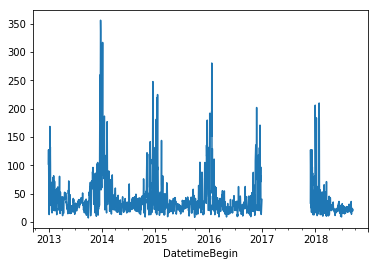

In [17]:
# Check out the overall trend of pollution (resampling by Day). We see that for the most part the 2017 data is missing
df.set_index('DatetimeBegin').sort_index().resample('D')['Concentration'].mean().plot()

<Figure size 1008x1296 with 0 Axes>

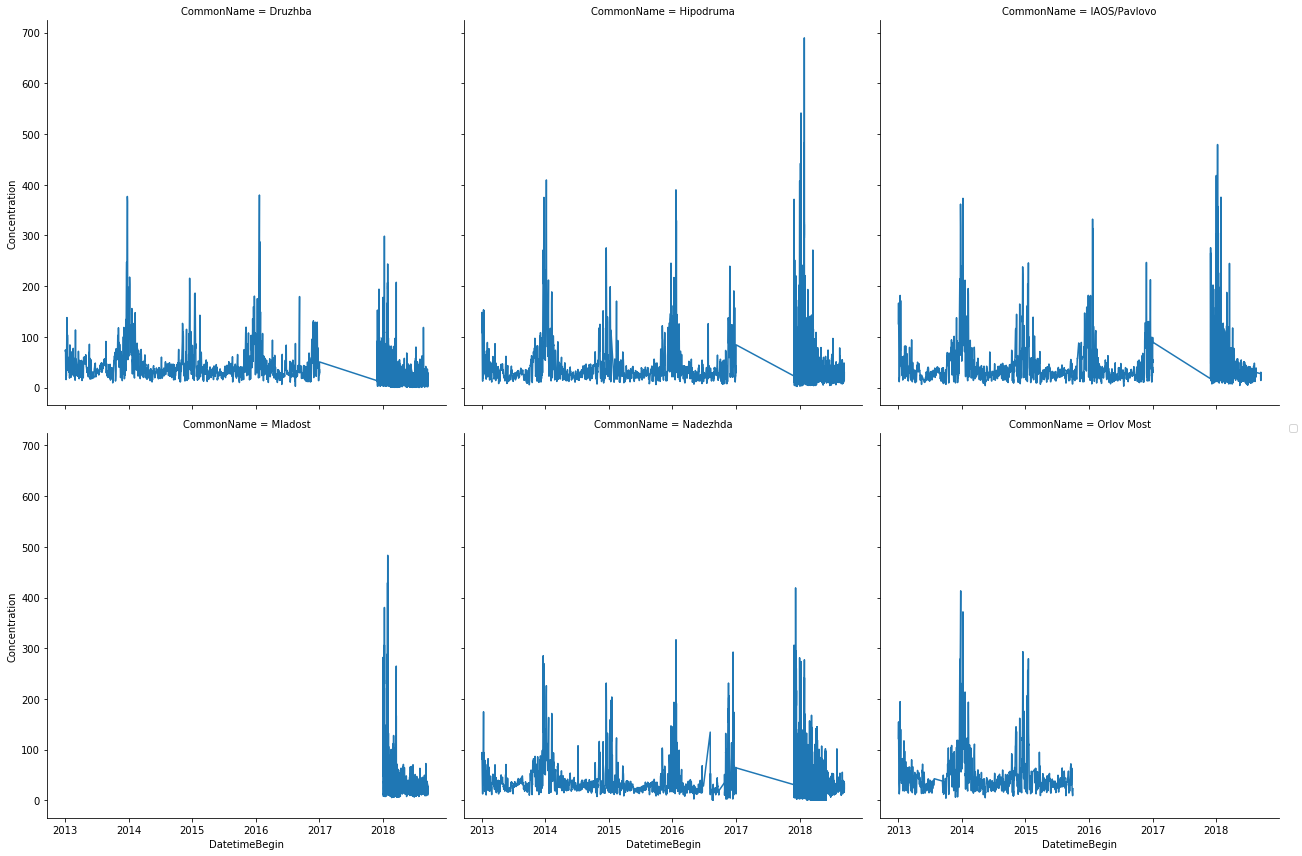

<Figure size 1008x1296 with 0 Axes>

In [18]:
# Visualize the average contentration by station. The clear trend is seen that the 
# air pollution is drastic towards the end and the beginning of the year compared to all other periods
# There is missing data for the most part of 2017 and some stations are missing a lot of data altogether (Mladost and Orlov Most)

g = sns.FacetGrid(df.sort_values(by='DatetimeBegin').groupby(['CommonName','DatetimeBegin'])['Concentration'].mean().reset_index(),col_wrap=3,col='CommonName',size=6)
g = g.map(plt.plot,'DatetimeBegin','Concentration').add_legend()
plt.figure(figsize=(14,18))

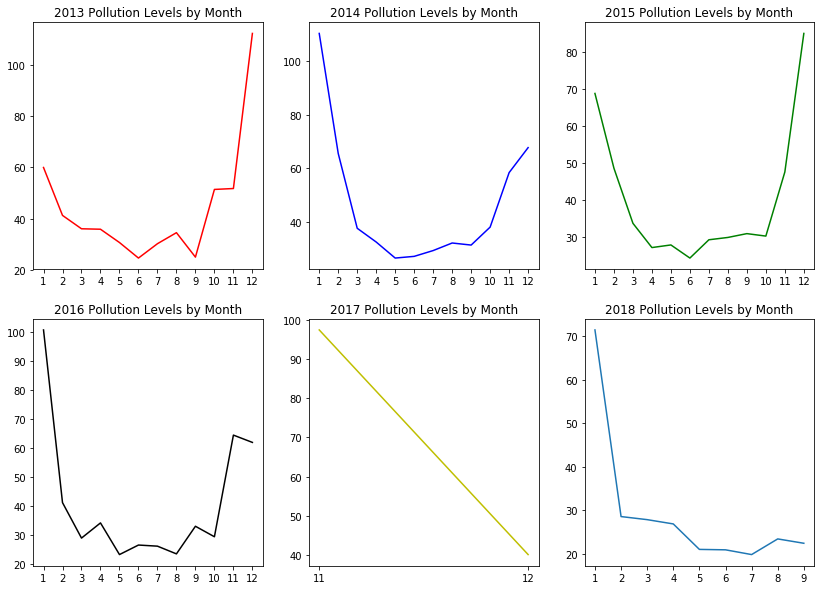

In [19]:
#Plot the overall data by year and month. We see pollution is lowest in the summer months and highest in the winter months

fig, ax = plt.subplots(2, 3,figsize=(14,10))
plt.setp(ax, xticks=list(np.arange(1,13,1)))

ax[0,0].plot(stations_month_day.loc[stations_month_day['Year']==2013].groupby('Month')['Concentration'].mean(),'r',)
ax[0,0].title.set_text('2013 Pollution Levels by Month')
ax[0,1].plot(stations_month_day.loc[stations_month_day['Year']==2014].groupby('Month')['Concentration'].mean(), 'b')
ax[0,1].title.set_text('2014 Pollution Levels by Month')
ax[0,2].plot(stations_month_day.loc[stations_month_day['Year']==2015].groupby('Month')['Concentration'].mean(), 'g')
ax[0,2].title.set_text('2015 Pollution Levels by Month')
ax[1,0].plot(stations_month_day.loc[stations_month_day['Year']==2016].groupby('Month')['Concentration'].mean(), 'k')
ax[1,0].title.set_text('2016 Pollution Levels by Month')
ax[1,1].plot(stations_month_day.loc[stations_month_day['Year']==2017].groupby('Month')['Concentration'].mean(), 'y')
ax[1,1].title.set_text('2017 Pollution Levels by Month')
ax[1,2].plot(stations_month_day.loc[stations_month_day['Year']==2018].groupby('Month')['Concentration'].mean())
ax[1,2].title.set_text('2018 Pollution Levels by Month')

In [21]:
# Create a dataframe to group Pollution by day
day=(stations_month_day
         .groupby(['Month','Year','Day'])['Concentration']
         .mean()
         .unstack()
         .reset_index()
         .set_index('Month'))

In [22]:
# Create a dataframe used to plot a heatmap by month and hour in the day
hour_month=stations_hour.groupby(['Month','Hour'])['Concentration'].mean().unstack().reset_index().set_index('Month')

Text(0.5,1,'Average Pollution by Month and Hour  in µg/m3 (AvgTime=Hour only)')

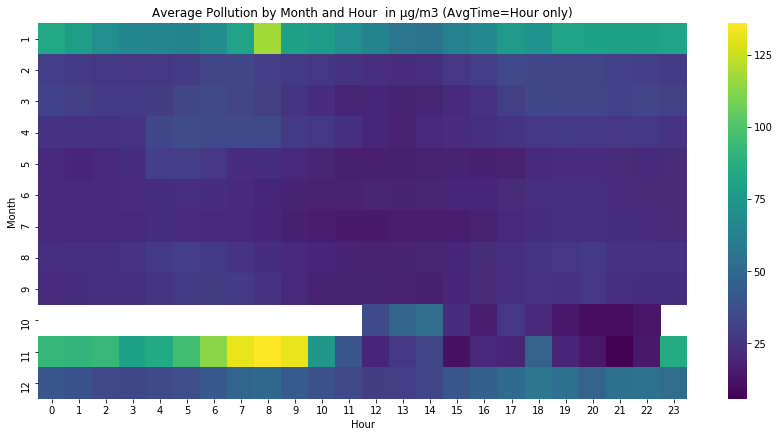

In [23]:
# We see that the mornings of November and January seem heavily polluted. 
# However if we recall not all the data is samples taken by the hours so we need to do a heatmap by calendar days as well
f,ax=plt.subplots(figsize=(12,6))
sns.heatmap(hour_month,cmap='viridis',ax=ax)
ax.figure.tight_layout()
fig = ax.get_figure()
plt.title('Average Pollution by Month and Hour  in µg/m3 (AvgTime=Hour only)')

In [24]:
# Creating dataframes for each year
h2013=day[day['Year']==2013].drop(columns='Year')
h2014=day[day['Year']==2014].drop(columns='Year')
h2015=day[day['Year']==2015].drop(columns='Year')
h2016=day[day['Year']==2016].drop(columns='Year')
h2017=day[day['Year']==2017].drop(columns='Year')
h2018=day[day['Year']==2018].drop(columns='Year')

(<matplotlib.axes._subplots.AxesSubplot at 0xe1add68>,
 Text(0.5,1,'2016'),
 None)

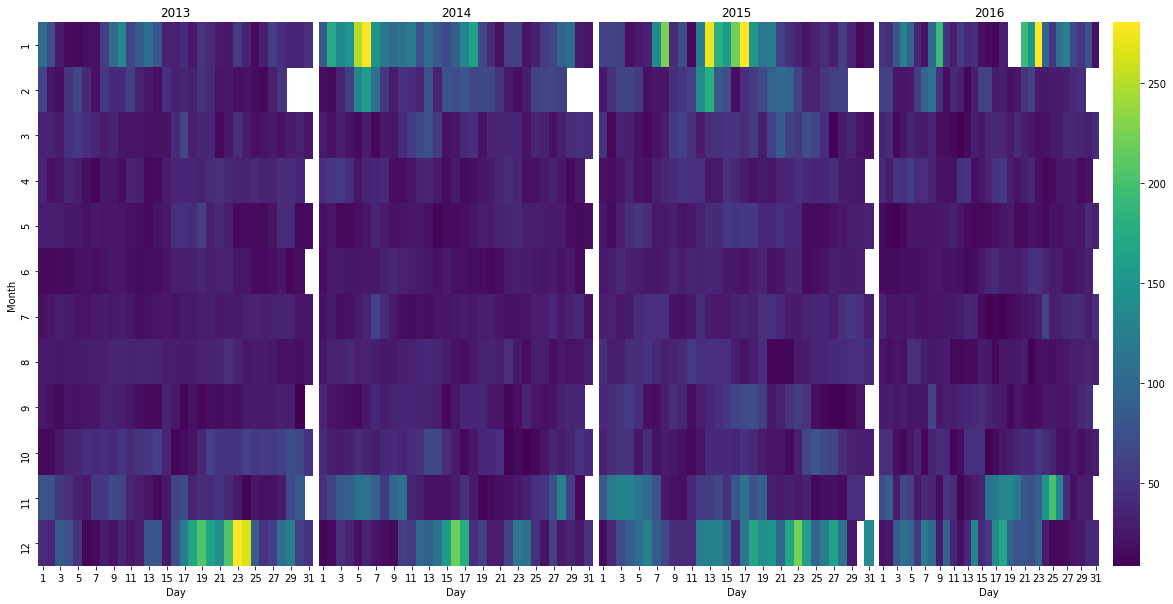

In [25]:
# Plotting them for 2013-2016
fig,(ax,ax2,ax3,ax4) = plt.subplots(ncols=4)
fig.set_size_inches(20,10)
fig.subplots_adjust(wspace=0.02)
sns.heatmap(h2013, cmap="viridis", ax=ax, cbar=False),ax.set_title('2013')
sns.heatmap(h2014, cmap="viridis", ax=ax2, cbar=False,yticklabels=False),ax2.set_title('2014'),ax2.yaxis.label.set_visible(False)
sns.heatmap(h2015, cmap="viridis", ax=ax3, cbar=False,yticklabels=False),ax3.set_title('2015'),ax3.yaxis.label.set_visible(False)
sns.heatmap(h2016, cmap="viridis", ax=ax4,yticklabels=False),ax4.set_title('2016'),ax4.yaxis.label.set_visible(False)

# We see that from 2013 to 2015 there is a heavy pollution in the days before and around Christmas 
# (don't want to be there at that time of year). We also see pollution increasing in the 2nd half of Jan

(<matplotlib.axes._subplots.AxesSubplot at 0xc8c63c8>,
 Text(0.5,1,'2018'),
 None)

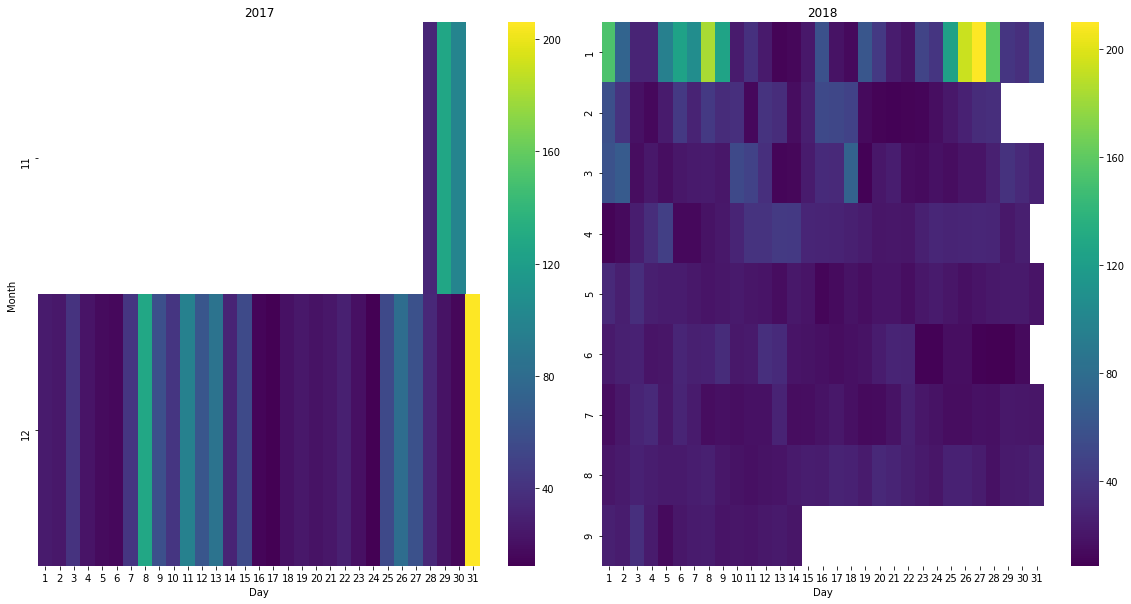

In [26]:
# Let's plot this for 2017 and 208 as well. As we can see there is a lot of missing data and specifically for 
#2018 you can again see high level of pollution towards the end of January

fig,(ax,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,10)
fig.subplots_adjust(wspace=0.02)
sns.heatmap(h2017, cmap="viridis", ax=ax),ax.set_title('2017')
sns.heatmap(h2018, cmap="viridis", ax=ax2),ax2.set_title('2018'),ax2.yaxis.label.set_visible(False)

In [27]:
# Ok let's quickly explore the air data.
# Check if two datasets have the same columns
set(air_17.columns)-set(air_18.columns)

set()

In [28]:
# Merge them
air_total=pd.concat([air_17,air_18])

In [29]:
# Check the data type
air_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3610146 entries, 0 to 2958653
Data columns (total 7 columns):
time           object
geohash        object
P1             int64
P2             int64
temperature    int64
humidity       int64
pressure       int64
dtypes: int64(5), object(2)
memory usage: 220.3+ MB


In [30]:
# Change the time format to datetime
air_total['time']=pd.to_datetime(air_total['time'])

In [31]:
# We will use pygeohash to convert the geohash in lat lon
# But first we need to remove a strange geohashing format which could be a typo
air_total=air_total[air_total['geohash']!='m-2105171']

In [32]:
air_total.head()

,time,geohash,P1,P2,temperature,humidity,pressure
0,2017-09-06 20:00:00,sx8d5r7wmxr,9,8,14,55,0
1,2017-09-06 20:00:00,sx8d6zjg5h8,9,8,0,0,0
2,2017-09-06 20:00:00,sx8dk3k2wr6,8,7,15,52,92655
3,2017-09-06 20:00:00,sx2rj28e0gs,5,5,18,47,97448
4,2017-09-06 20:00:00,sx82v69m2jt,1,1,11,68,94823


In [33]:
# Let's get some statistics by geohash
grouped=air_total.groupby('geohash').agg({'temperature':[max,min,np.mean],
     'humidity':[max,min,np.mean],
     'pressure':[max,min,np.mean],
     'time':[lambda x: x.max() - x.min(),max,min]})

grouped.columns = grouped.columns.map('_'.join)
grouped.rename(columns={'time_<lambda>':'days_difference'},inplace=True)
grouped.reset_index(inplace=True)
grouped.head()

,geohash,temperature_max,temperature_min,temperature_mean,humidity_max,humidity_min,humidity_mean,pressure_max,pressure_min,pressure_mean,days_difference,time_max,time_min
0,sx27rxfj4me,37,-6,15.373494,99,18,64.641867,101752,97555,99725.227861,286 days 01:00:00,2018-08-16 12:00:00,2017-11-03 11:00:00
1,sx2qvkkjjkh,39,10,23.434324,100,13,57.700156,98244,96229,97420.616106,109 days 11:00:00,2018-08-16 12:00:00,2018-04-29 01:00:00
2,sx2qvtugtp2,43,-1,22.464619,100,0,56.045394,97609,0,95941.020360,142 days 18:00:00,2018-08-16 06:00:00,2018-03-26 12:00:00
3,sx2qvwhct1b,29,-14,5.902409,93,22,67.334831,98359,94275,96432.270723,102 days 12:00:00,2018-03-26 11:00:00,2017-12-13 23:00:00
4,sx2qvy4xrkm,43,8,20.852368,100,12,53.630919,97914,95671,96915.236769,40 days 18:00:00,2017-10-17 14:00:00,2017-09-06 20:00:00


In [34]:
# Now let's convert the geohash to lat and lon
grouped['latlon']=grouped['geohash'].apply(lambda x: gh.decode(str(x)))
grouped[['latitude', 'longitude']] = grouped['latlon'].apply(pd.Series)
grouped.drop(columns='latlon',inplace=True)

In [35]:
print('There are {} unique stations to plot on a map'.format(grouped['geohash'].nunique()))

There are 1263 unique stations to plot on a map


In [36]:
# Now we can plot them to see if we have a good coverage

import folium
from folium.plugins import MarkerCluster

# let's start again with a clean copy of the map of Sofia
sof_map = folium.Map(location = [latitude, longitude], zoom_start = 12)


# instantiate a mark cluster object for the incidents in the dataframe
incidents = folium.plugins.MarkerCluster().add_to(sof_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(grouped.latitude, grouped.longitude, grouped['geohash']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# display map
sof_map